In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing Necessary Libraries

In [0]:
import glob
import cv2
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
from sklearn.metrics import classification_report

# About Dataset
The dataset used for this project had been collected by the students of University. Photographs were clicked in different lighting conditions, with different backgrounds and in different poses with different angles. 

# Loading paths of dataset images
I used Google Drive to store dataset. For loading dataset directly from google drive we need to mount drive on google colab and then give folder path for destination folder where the dataset has been stored. After this, for each image present in the dataset, we need to save label in a list. 
The folder structure is as follows:

In [0]:
files = glob.glob("/content/gdrive/My Drive/VR/Project - Face recognition/AVR_data/**/*.jpg")
paths = []
names = []
 
for file in files:
  label_str = file.split("/")[-2]
  paths.append(file)
  names.append(label_str)

# Function to preprocess images
All the images should be made of same size and grayscale. This reduces reduces dimensions of the image matrix.

In [0]:
def preprocess(image):
  #convert images to grayscale
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

  #resize image to 64x64 pixels
  standard_im = cv2.resize(gray, (64, 64))
  
  return standard_im

Label Encoding of labels to convert English names to numbers

In [0]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
names= label_encoder.fit_transform(names) 



Load images from loaded paths and preprocessing them

In [0]:
data = []
for path in paths:

  #Read image using imread() function
  img = cv2.imread(path)
  
  #preprocess them into grayscale and standard size
  pre = preprocess(img)

  #append result of preprocessing into a list of images
  data.append(pre)

# Implementation of PCA


In [0]:
#creating a list of face vectors
face_vector = []

#adding data into face_vector array as a numpy array for further processing
face_vector = np.asarray(data)

#reshaping data matrix in order to flatten the images into 1 dimension
face_vector_reshaped = face_vector.reshape(4096,len(data))

Step-1 PCA - Standardization of data matrix


In [0]:
#using standard scalar to standardize matrix data
face_std = StandardScaler().fit_transform(face_vector_reshaped)

#taking transpose of data matrix in order to proceed further for PCA
face_vector_transposed = face_std.transpose()

Step - 2 PCA - Normalizing data matrix

In [0]:
#In order to normalize data matrix, first find mean of every column and store it into a row vector
avg_face_vector = face_vector_transposed.mean(axis=1)

#Reshape the row vector into a 2-d matrix with nx1 dimension (n be total number of images in dataset)
avg_face_vector = avg_face_vector.reshape(face_vector.shape[0], 1)

#Finally subtract mean of every column from every data entry in data matrix
normalized_face_vector = face_vector_transposed - avg_face_vector

Step - 3 PCA -Calculate Co - Variance Matrix

In [0]:
#Covariance matrix is nothing but dot product of data matrix and its transpose
covariance_matrix = np.cov(np.transpose(normalized_face_vector))

#finding if all the values of covariance matrix are real or complex
print(np.unique(np.isreal(covariance_matrix)))

if (np.unique(np.isreal(covariance_matrix)) == True):
  print("It implies covariance matrix has all the real values in it. and its symmetric as well, thus its eigen values should be real.")
else:
  print("covariance matrix has complex")

[ True]
It implies covariance matrix has all the real values in it. and its symmetric as well, thus its eigen values should be real.


Step - 4 PCA - Calculate the Eigen Values and Eigen Vectors

In [0]:
#finding eigen values with the help of Linear Algebra Library's function eig()
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

Step - 5 PCA - Sort Eigen values in descending order

In [0]:
#Now we need to know how many eigen value contribute in more than 95% of the variance.
tot = sum(eigen_values)

#Finding variance contributed by each eigen vector
var_exp = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]

#storing the cumulative variance
cum_var_exp = np.cumsum(var_exp)

/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


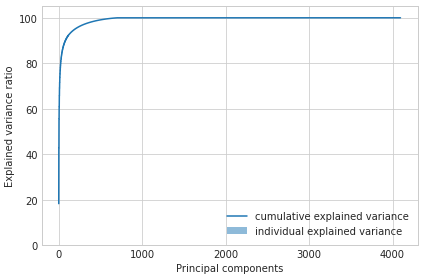

In [0]:
#Lets plot the graph to know how much variance is captured by some top k eigen vectors.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4096), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4096), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

So as we can see 95% of the variance can be obtained in 400 components. So we need to just take top 400 eigen vectors. This is how dimensionality got reduced from 4096 dimensions to 400 dimensions.

In [0]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
544.7313988139222
522.5643273237089
209.02696139117847
188.79596597695001
188.5192465643821
81.07636633708238
78.84144571770392
72.24168628982018
69.1965307841264
62.262407668231404
40.88516689803873
39.1695002982139
36.43749898751818
35.09959665695911
26.342230856395847
25.465165963476966
24.135048030752472
21.04393187258311
20.286950066896015
19.583382028909444
17.979622785843862
17.232444305060604
16.14624825098464
13.412405777095508
12.946078682509814
12.771636139993328
11.871524474690295
11.55857374529989
11.487082332408283
10.799946898457245
8.874824723644801
8.399828481541222
8.262531553548138
8.110547821589256
7.835830374719716
7.637443897068028
7.481678166121872
7.134911554170937
6.75698201329647
6.268198550073259
6.218009713758703
6.08863924285369
5.952549708509204
5.735718950472061
5.608670966398411
5.519771215672903
5.223072145104321
4.883583508112125
4.823864834598349
4.731304789023035
4.6704494749489935
4.517634992595129
4.408142038846891


In [0]:
#matrix_w will be the final matrix with only 400 dimensions
matrix_w = np.hstack((eig_pairs[i][1].reshape(4096,1))for i in range(400))

#lets confirm it by printing
print(matrix_w.shape)

(4096, 400)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Step - 6 PCA - Projection on to new space

In [0]:
#Projecting our data matrix onto new dimensions is nothing but taking dot product of new matrix with the transpost of standardized data matrix
pca = face_std.T.dot(matrix_w)

#checking the shape of matrix obtained by printing
print(pca.shape)

(710, 400)


PCA IS DONE. Now lets prepare our data for modelling

In [0]:
#This will eleminate the imaginary part of data if any.
pca_real = pca.real

# Splitting data into training and testing

In [0]:
# Using sklearn library we splitted data by 70 - 30 ratio
x_train, x_test, y_train, y_test = train_test_split(pca_real, names,test_size= 0.3)

# Applying Model

In [0]:
#SVM is chosen as a model for predicting faces

#initialize object
clf = SVC(kernel='rbf',C=1000,gamma=0.001)

#fit train data into the model
clf = clf.fit(x_train, y_train)
#Predicting values and storing result into numoy array
y_pred = clf.predict(x_test)

#Printing the precision, recal, f1_score and final accuracy of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         6
           4       1.00      0.50      0.67         8
           5       0.50      1.00      0.67         3
           6       1.00      0.80      0.89        10
           7       0.62      1.00      0.77         5
           8       0.75      1.00      0.86         3
           9       0.86      0.75      0.80         8
          10       0.60      1.00      0.75         3
          11       1.00      0.67      0.80         6
          12       1.00      0.83      0.91         6
          13       0.83      1.00      0.91         5
          14       0.60      1.00      0.75         6
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         3
          17       0.75    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
